## Logistic Regression with PCA(100) on Image and Text Embeddings 


Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In [1]:
#  Here we make all the imports required 
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from tqdm.notebook import tqdm, trange
import json

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Importing all the Concat Embeddings of Text and Images reducing them to 100 dim using PCA. 

In [3]:
concat_embeddings = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [4]:
concat_embeddings_val = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_dev_unseen.csv")
concat_embeddings_val.rename(columns={"0": "id"}, inplace=True)

In [5]:
concat_embeddings_test_unseen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_test_unseen.csv")
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)
concat_embeddings_test_seen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_test_seen.csv")
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

Importing all the JSON Files 

In [6]:
train_data = pd.read_json("/content/gdrive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
# batch_size = 32
# chunked_data = split_dataframe(train_data, batch_size)

(8500, 4)

In [7]:
val_data = pd.read_json("/content/gdrive/MyDrive/522-project/dev_unseen.jsonl", lines=True)
val_data.head()
val_data.shape

(540, 4)

In [8]:
test_unseen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_unseen.jsonl", lines=True)
test_unseen_data.head()
test_unseen_data.shape

(2000, 4)

In [9]:
test_seen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_seen.jsonl", lines=True)
test_seen_data.head()
test_seen_data.shape

(1000, 4)

In [10]:
train_embed = concat_embeddings[concat_embeddings.id.isin(train_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
target_train = train_data["label"].tolist()
print(len(train_embed))

8500


In [11]:
val_embed= concat_embeddings_val[concat_embeddings_val.id.isin(val_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
val_target = val_data["label"].tolist()
len(val_embed)

540

In [12]:
test_unseen_embed= concat_embeddings_test_unseen[concat_embeddings_test_unseen.id.isin(test_unseen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_unseen_target = test_unseen_data["label"].tolist()
len(test_unseen_embed)
len(test_unseen_target)

2000

In [13]:
test_seen_embed= concat_embeddings_test_seen[concat_embeddings_test_seen.id.isin(test_seen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_seen_target = test_seen_data["label"].tolist()
len(test_seen_embed)

1000

Fitting the cocatenated Train embedding on the Logistic Regression 

In [14]:
#clf = LogisticRegression(random_state=0, max_iter=9000,penalty='l1',solver='liblinear', C=0.085).fit(train_embed, target_train)
#clf = LogisticRegression(random_state=0, max_iter=500,penalty='elasticnet',solver='saga', C=0.4, l1_ratio=0.6).fit(train_embed, target_train)
clf = LogisticRegression(random_state=0, max_iter=9000,penalty='elasticnet',solver='saga', l1_ratio=0.5).fit(train_embed, target_train)

#C=0.4

## Testing on the Validation Set

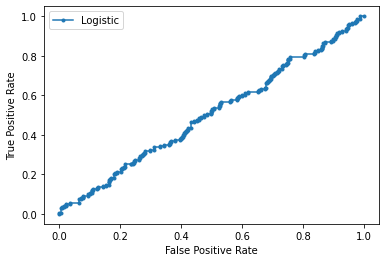

precision :0.38857142857142857 recall :0.34 f1 :0.36266666666666664 accuracy :0.5574074074074075


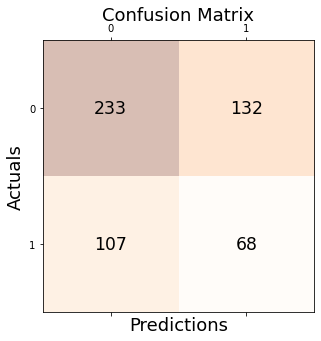

Precision vs Recall


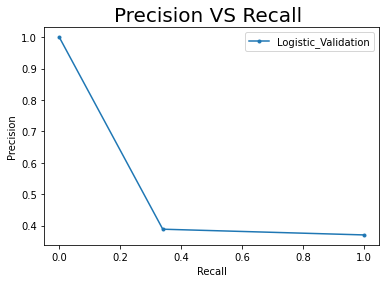

In [15]:



preds = clf.predict(val_embed)
lr_probs = clf.predict_proba(val_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(val_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(val_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(val_target, preds, average='binary')
acc = accuracy_score(val_target, preds)
r = confusion_matrix(preds, val_target)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(val_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='Logistic_Validation')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [16]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.5040441176470588


## Testing on Test Seen Data

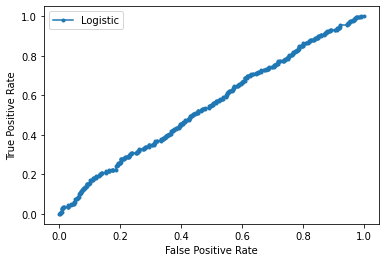

precision :0.5492424242424242 recall :0.29591836734693877 f1 :0.38461538461538464 accuracy :0.536


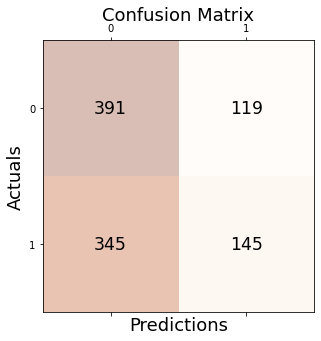

Precision vs Recall


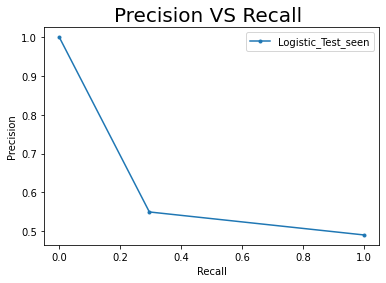

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


preds = clf.predict(test_seen_embed)
lr_probs = clf.predict_proba(test_seen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_seen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_seen_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_seen_target, preds, average='binary')
acc = accuracy_score(test_seen_target, preds)

r = confusion_matrix(test_seen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(test_seen_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='Logistic_Test_seen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [18]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.5473869547819128


## Testing on the unseen test data

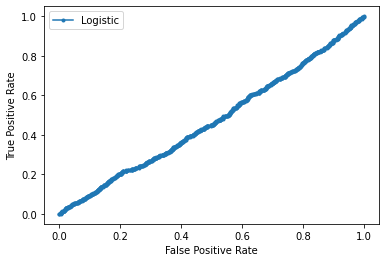

precision :0.351575456053068 recall :0.2826666666666667 f1 :0.3133776792313378 accuracy :0.5355


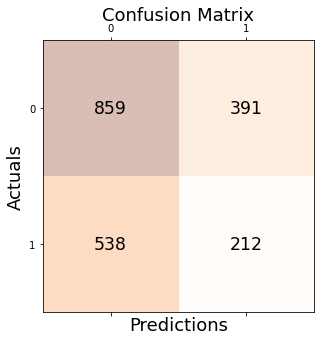

Precision vs Recall


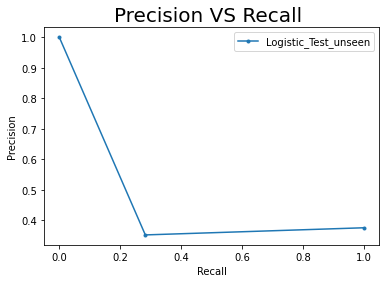

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


preds = clf.predict(test_unseen_embed)
lr_probs = clf.predict_proba(test_unseen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_unseen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_unseen_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_unseen_target, preds, average='binary')
acc = accuracy_score(test_unseen_target, preds)
r = confusion_matrix(test_unseen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision1, recall1, thresholds = precision_recall_curve(test_unseen_target, preds)
print("Precision vs Recall")
pyplot.plot(recall1, precision1, marker='.', label='Logistic_Test_unseen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [20]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.4726826666666667


We fine tuned this on various regularization penalties such as l1, l2, elastic net. We also fine tuned on maximum number of iterations and solvers (such as saga)